# Monocular Depth Estimation - Pix2Pix Model
This noteook contains the implementation of Pix2Pix model in PyTorch that has been adapted for depth estimation. The DIODE (Dense Indoor and Outdoor DEpth Dataset) validation dataset has been used for training and testing the model. However, other dataset can be easily adapted into the dataset.

## Setting up the environment
Import all the necessary packages for importing the dataset, defining the model and visualizing the performance.

In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F


from PIL import Image
from IPython import display
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from skimage.metrics import structural_similarity as compare_ssim

import matplotlib.pyplot as plt

import os
import cv2
import time
import numpy as np
import random
import glob

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The Dataset
This notebook uses the DIODE (Dense Indoor Outdoor DEpth Dataset) for training and measuring the performance of the model.

<div class="alert alert-block alert-info">
<b>Tip:</b> In order to make train and get inference of the model on a different dataset. Simply modify the MDataset class to load and produce the RGB and Depth (Ground-truth) images
</div>

In [2]:
class MDataset(Dataset):
    DATASET_DIRECTORY = '/kaggle/input/monocular-depth-estimation/val/indoors'
    def __init__(self, img_size=256, batch_size = 16, num_workers=0):
        super(Dataset, self).__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers
        self.images = {}

        for subdir, dirs, files in os.walk(MDataset.DATASET_DIRECTORY):
          for file in files:
            basename = os.path.basename(os.path.join(subdir, file))
            if basename[-3:] == "png":
              basename = basename[:-4]
              kind = "rgb"
            elif basename[-9:] == "depth.npy":
              basename = basename[:-10]
              kind = "depth"
            elif basename[-14:] == "depth_mask.npy":
              basename = basename[:-15]
              kind = "mask"
            else:
              continue

            if not basename in self.images:
              self.images[basename] = { "rgb": None, "depth": None, "mask": None }
            self.images[basename][kind] = os.path.join(subdir, file)
            
        self.names = list(self.images.keys())
        
    def __len__(self):
        return len(self.names)
    
    @staticmethod
    def normalize(img):
        return (img * 2) - 1
    
    @staticmethod
    def denormalize(img):
        return (img * 0.5) + 0.5

    def __getitem__(self, idx):
        name = self.names[idx]
        
        rgb = Image.open(self.images[name]['rgb'])
        rgb = np.array(rgb)
        rgb = ((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)))
        rgb = rgb.astype(np.float32)
        rgb = np.nan_to_num(rgb)
        
        depth = self.images[name]["depth"]
        depth = np.load(depth).squeeze()

        mask = self.images[name]["mask"]
        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth, 99))
        depth = np.clip(depth, 0.1, max_depth)
        depth = np.log(depth, where=mask)
        depth = np.ma.masked_where(~mask, depth)
        depth = np.clip(depth, 0.1, np.log(max_depth))
        depth = np.expand_dims(depth, axis=2)
        depth = np.concatenate([depth] * 3, axis=2)
        depth = ((depth - np.min(depth)) / (np.max(depth) - np.min(depth)))
        depth = np.nan_to_num(depth)
        depth = depth.astype(np.float32)
        
        rgb, depth = torch.from_numpy(rgb), torch.from_numpy(depth)
        rgb, depth = rgb.permute(2, 0, 1), depth.permute(2, 0, 1)
        rgb = transforms.Resize((256, 256))(rgb)
        depth = transforms.Resize((256, 256))(depth)
        
        return MDataset.normalize(rgb), MDataset.normalize(depth)

## Pix2Pix Model
The following code blocks contain the PyTorch implementation of the Pix2Pix model.

In [3]:
class ConvBlock(nn.Module):
    """
    A customizable convolutional block module for neural networks.

    Args:
    - input_size (int): Number of input channels.
    - output_size (int): Number of output channels.
    - kernel_size (int, optional): Size of the convolutional kernel. Default is 4.
    - stride (int, optional): Stride of the convolution. Default is 2.
    - padding (int, optional): Padding applied to the input. Default is 1.
    - activation (bool, optional): Whether to apply LeakyReLU activation. Default is True.
    - batch_norm (bool, optional): Whether to apply batch normalization. Default is True.

    Attributes:
    - conv (torch.nn.Conv2d): Convolutional layer.
    - activation (bool): Flag indicating whether activation is applied.
    - lrelu (torch.nn.LeakyReLU): LeakyReLU activation function.
    - batch_norm (bool): Flag indicating whether batch normalization is applied.
    - bn (torch.nn.BatchNorm2d): Batch normalization layer.

    Methods:
    - forward(x): Performs forward pass through the convolutional block.

    Returns:
    - torch.Tensor: Output tensor after applying convolution, activation, and batch normalization.
    """
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out

In [4]:
class DeconvBlock(nn.Module):
    """
    A customizable deconvolutional block module for neural networks.

    Args:
    - input_size (int): Number of input channels.
    - output_size (int): Number of output channels.
    - kernel_size (int, optional): Size of the deconvolutional kernel. Default is 4.
    - stride (int, optional): Stride of the deconvolution. Default is 2.
    - padding (int, optional): Padding applied to the input. Default is 1.
    - batch_norm (bool, optional): Whether to apply batch normalization. Default is True.
    - dropout (bool, optional): Whether to apply dropout. Default is False.

    Attributes:
    - deconv (torch.nn.ConvTranspose2d): Deconvolutional layer.
    - bn (torch.nn.BatchNorm2d): Batch normalization layer.
    - drop (torch.nn.Dropout): Dropout layer.
    - relu (torch.nn.ReLU): ReLU activation function.
    - batch_norm (bool): Flag indicating whether batch normalization is applied.
    - dropout (bool): Flag indicating whether dropout is applied.

    Methods:
    - forward(x): Performs forward pass through the deconvolutional block.

    Returns:
    - torch.Tensor: Output tensor after applying deconvolution, activation, batch normalization, and dropout if specified.
    """
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out

In [5]:
class Generator(nn.Module):
    """
    A conditional generator module for image synthesis using a U-Net architecture.

    Args:
    - input_dim (int): Dimensionality of the input noise vector.
    - num_filter (int): Number of filters in the first layer, which is then multiplied by 2 in each subsequent layer.
    - output_dim (int): Number of channels in the output image.

    Attributes:
    - conv1 to conv8 (ConvBlock): Encoder blocks for feature extraction.
    - deconv1 to deconv8 (DeconvBlock): Decoder blocks for image synthesis.
    
    Methods:
    - forward(x): Performs forward pass through the generator.
    - normal_weight_init(mean=0.0, std=0.02): Initializes the weights of the convolutional and deconvolutional layers.

    Returns:
    - torch.Tensor: Output tensor representing the synthesized image.
    """
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv8 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 8)
        self.deconv5 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv6 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv7 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv8 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)

In [6]:
class Discriminator(torch.nn.Module):
    """
    A discriminator module for binary classification in a conditional GAN.

    Args:
    - input_dim (int): Number of input channels.
    - num_filter (int): Number of filters in the first layer, which is then multiplied by 2 in each subsequent layer.
    - output_dim (int): Dimensionality of the output (1 for binary classification).

    Attributes:
    - conv1 to conv5 (ConvBlock): Convolutional blocks for feature extraction.
    
    Methods:
    - forward(x, label): Performs forward pass through the discriminator.
    - normal_weight_init(mean=0.0, std=0.02): Initializes the weights of the convolutional layers.

    Returns:
    - torch.Tensor: Output tensor representing the probability of input being real.
    """
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8, stride=1)
        self.conv5 = ConvBlock(num_filter * 8, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)

## Notebook Parameters
This section contains all the hyper-parameters that can be tuned for inteference

In [7]:
BATCHES_PER_EPOCH=16
NUM_EPOCH        =250
IMG_WIDTH        =256
IMG_HEIGHT       =256
LEARNING_RATE    =0.001
NUM_FILTERS      =64
INPUT_IMAGE_DIM  =3
OUTPUT_IMAGE_DIM =3
LAMBDA           =100

## Instancing the Model

In [8]:
device_type = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

if device_type == "cpu":
    print("Network moved to CPU as no GPU devices were identified")
else:
    print("Network moved to GPU")

G = Generator(INPUT_IMAGE_DIM, NUM_FILTERS, OUTPUT_IMAGE_DIM)
D = Discriminator(INPUT_IMAGE_DIM + OUTPUT_IMAGE_DIM, NUM_FILTERS, 1)


G = G.to(device)
D = D.to(device)

Network moved to GPU


In [9]:
G_optimizer = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

BCE_loss = nn.BCELoss().to(device)
L1_loss  = nn.L1Loss().to(device)

In [10]:
train_data_loader = DataLoader(MDataset(), batch_size=BATCHES_PER_EPOCH, shuffle=True, num_workers=1)

In [11]:
def summarize_performance(generator, input, target):
    x_ = input.to(device)
    y_ = target.to(device)
    
    g_ = G(x_)
    
    x_, y_, g_ = MDataset.denormalize(x_).cpu(), MDataset.denormalize(y_).cpu(), MDataset.denormalize(g_).detach().cpu()
    
    for batch in range(max(BATCHES_PER_EPOCH // 4, 1)):
        plt.figure(figsize=(16, 16))
        
        plt.subplot(1, 3, 1)
        plt.title("Input (RGB) Image")
        plt.imshow(x_[batch].permute(1, 2, 0))
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title("Target (Depth Map) Image")
        plt.imshow(y_[batch].permute(1, 2, 0)[:,:,0], cmap='plasma')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title("Output (Depth Map) Image")
        plt.imshow(g_[batch].permute(1, 2, 0)[:,:,0], cmap='plasma')
        plt.axis('off')
        
        plt.show()
    psnrs = []
    ssims = []
    for batch in range(BATCHES_PER_EPOCH):
        depth     = y_[batch].permute(1, 2, 0).numpy()[:,:,0]
        gen_depth = g_[batch].permute(1, 2, 0).numpy()[:,:,0]
        
        psnrs.append(cv2.PSNR(depth, gen_depth, 1.0))
        ssims.append(compare_ssim(depth, gen_depth, data_range=gen_depth.max() - gen_depth.min()))

    return np.mean(psnrs), np.mean(ssims)

In [12]:
G_avg_losses = []
D_avg_losses = []
PSNR_avg     = []
SSIM_avg     = []

def train():
    step = 0
    start = time.time()
    for epoch in range(NUM_EPOCH):
        D_losses = []
        G_losses = []

        for i, (input, target) in enumerate(train_data_loader):

            # input & target image data
            x_ = Variable(input.to(device))
            y_ = Variable(target.to(device))

            # Train discriminator with real data
            D_real_decision = D(x_, y_).squeeze()
            real_ = Variable(torch.ones(D_real_decision.size()).to(device))
            D_real_loss = BCE_loss(D_real_decision, real_)

            # Train discriminator with fake data
            gen_image = G(x_)
            D_fake_decision = D(x_, gen_image).squeeze()
            fake_ = Variable(torch.zeros(D_fake_decision.size()).to(device))
            D_fake_loss = BCE_loss(D_fake_decision, fake_)

            # Back propagation
            D_loss = (D_real_loss + D_fake_loss) * 0.5
            D.zero_grad()
            D_loss.backward()
            D_optimizer.step()

            # Train generator
            gen_image = G(x_)
            D_fake_decision = D(x_, gen_image).squeeze()
            G_fake_loss = BCE_loss(D_fake_decision, real_)

            # L1 loss
            l1_loss = LAMBDA * L1_loss(gen_image, y_)

            # Back propagation
            G_loss = G_fake_loss + l1_loss
            G.zero_grad()
            G_loss.backward()
            G_optimizer.step()

            # loss values
            D_losses.append(D_loss.data.item())
            G_losses.append(G_loss.data.item())

            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  % (epoch+1, NUM_EPOCH, i+1, len(train_data_loader), D_loss.item(), G_loss.item()))

            step += 1

        D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
        G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

        # avg loss values for plot
        D_avg_losses.append(D_avg_loss)
        G_avg_losses.append(G_avg_loss)
        
        display.clear_output(wait=True)
        print(f"Time taken for epoch {epoch}: {time.time() - start:.2f} second(s)")
        start = time.time()
        
        x_, y_ = next(iter(train_data_loader))
        psnr, ssim = summarize_performance(G, x_, y_)
        
        PSNR_avg.append(psnr)
        SSIM_avg.append(ssim)

Time taken for epoch 249: 45.94 second(s)


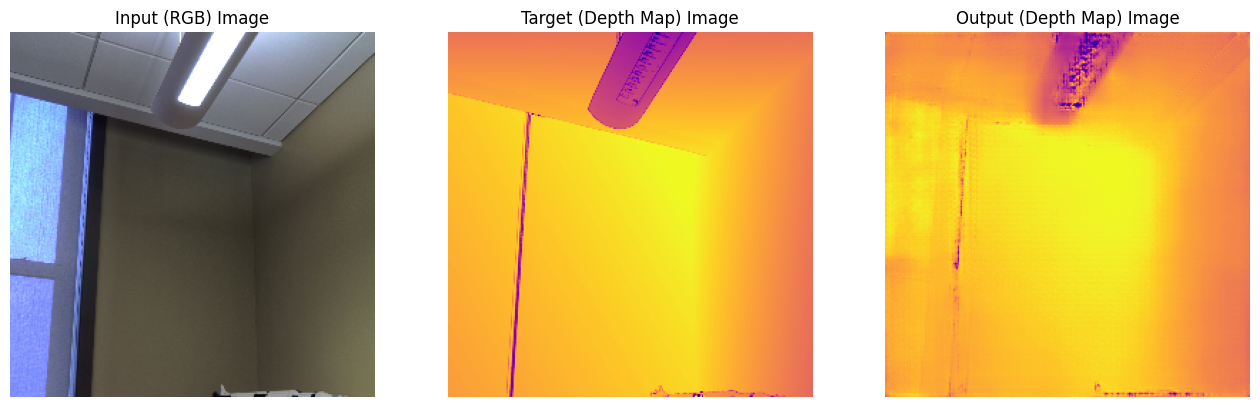

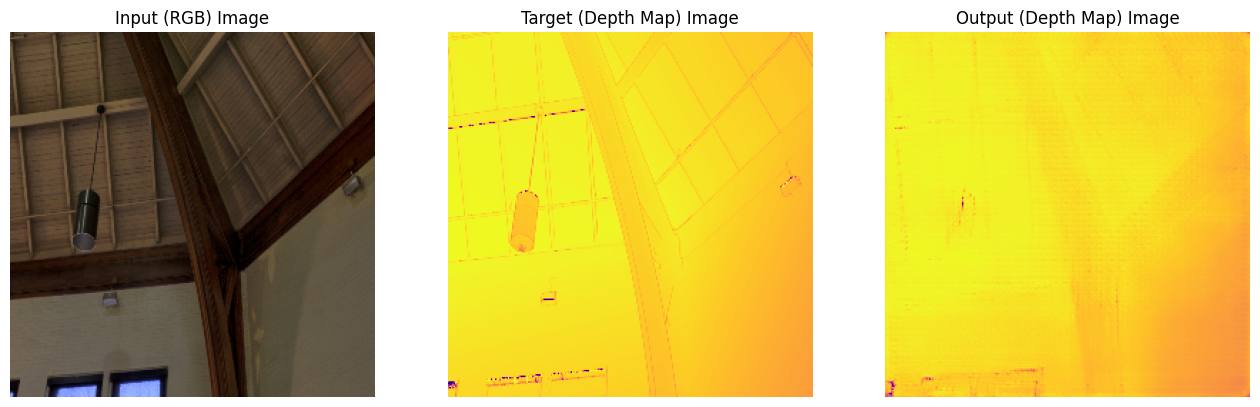

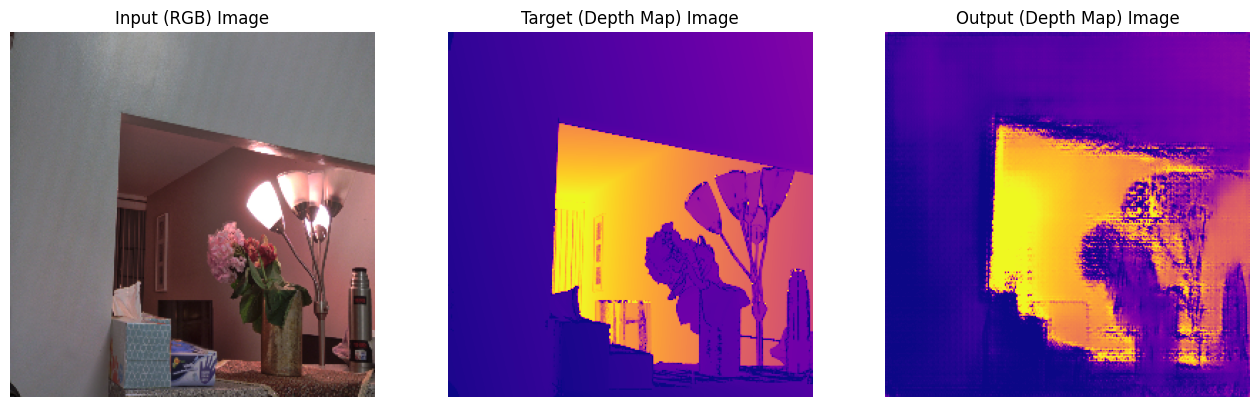

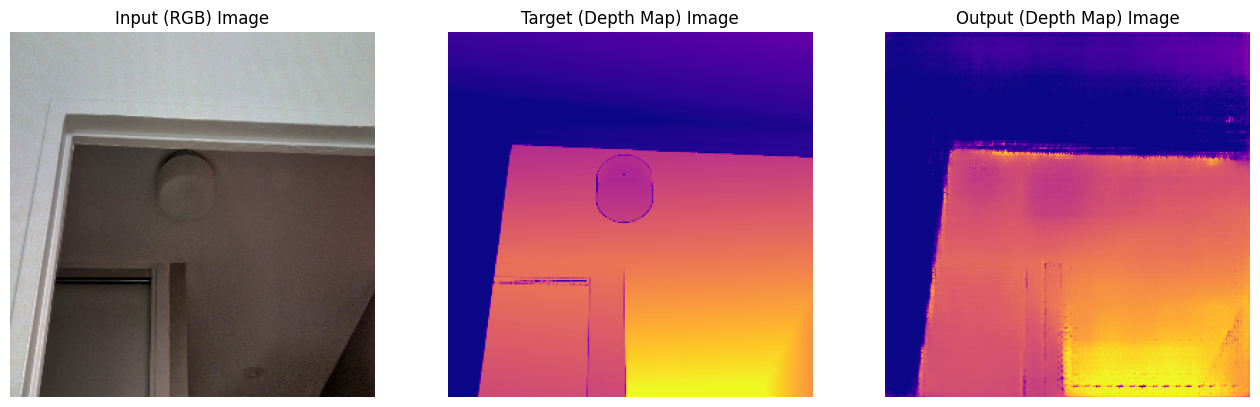

In [13]:
train()

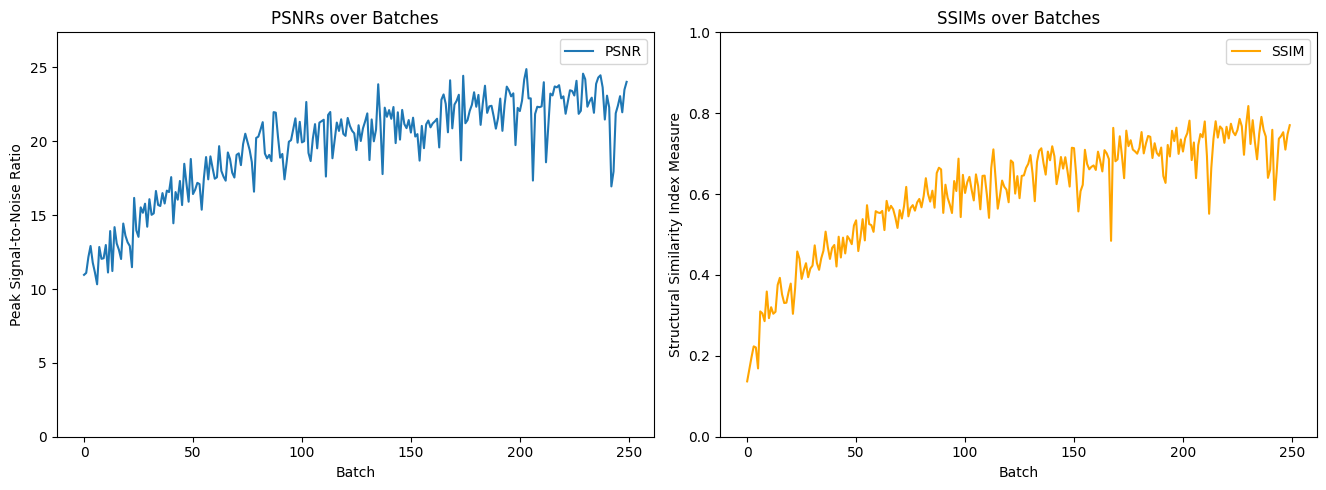

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.ylim(0, 1.1 * max(PSNR_avg))
plt.plot(PSNR_avg, label='PSNR')
plt.title('PSNRs over Batches')
plt.xlabel('Batch')
plt.ylabel('Peak Signal-to-Noise Ratio')
plt.legend()

# Plot SSIMs
plt.subplot(1, 3, 2)
plt.ylim(0.0, 1.0)
plt.plot(SSIM_avg, label='SSIM', color='orange')
plt.title('SSIMs over Batches')
plt.xlabel('Batch')
plt.ylabel('Structural Similarity Index Measure')
plt.legend()

plt.tight_layout()
plt.show()

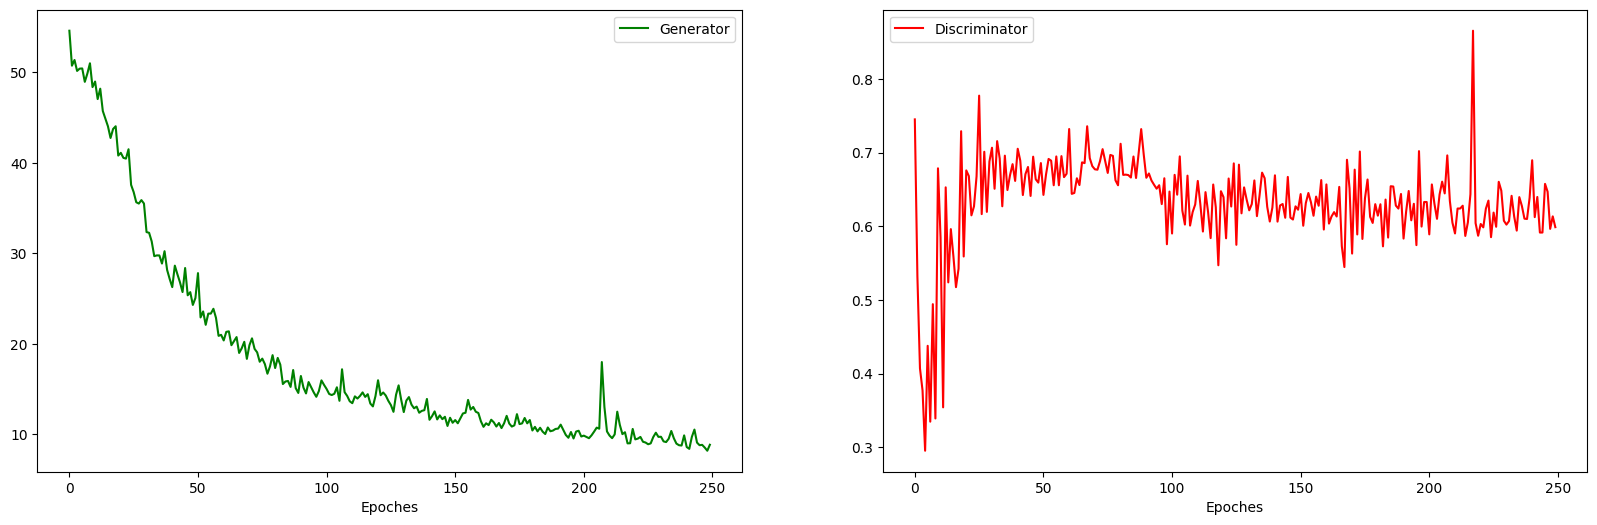

In [15]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(G_avg_losses, label='Generator', color='green')
plt.xlabel('Epoches')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(D_avg_losses, label='Discriminator', color='red')
plt.xlabel('Epoches')
plt.legend()

plt.show()